# Analyse der Filter

In [1]:
import numpy as np
import tensorflow as tf
import model_cnn
import preprocessing_classification as pre_c
np.set_printoptions(threshold=np.nan)
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import os, glob

In [2]:
sess = tf.InteractiveSession()

text_length = 1000
num_authors = 5
input_cnn = tf.placeholder(tf.float32, [None, len(pre_c.alphabet), text_length, 1], name="input_x")
with tf.variable_scope("cnn"):
    cnn_logits, cnn_variables, _ = model_cnn.inference(
            input_x=input_cnn, keep_prob=1.0, num_authors=num_authors)
known_vars = []
known_vars = tf.global_variables()
saver = tf.train.Saver(var_list=known_vars)
saver.restore(sess, "../resources/1511967049/saves/cnn.ckpt-00009384")
print("cnn_classifier restored")

INFO:tensorflow:Restoring parameters from ../resources/1511967049/saves/cnn.ckpt-00009384
cnn_classifier restored


In [3]:
w_1 = sess.run('cnn/conv-1/W:0')
b_1 = sess.run('cnn/conv-1/b:0')
w_2 = sess.run('cnn/conv-2/W:0')
b_2 = sess.run('cnn/conv-2/b:0')
w_3 = sess.run('cnn/conv-3/W:0')
b_3 = sess.run('cnn/conv-3/b:0')
w_4 = sess.run('cnn/conv-4/W:0')
b_4 = sess.run('cnn/conv-4/b:0')
w_5 = sess.run('cnn/conv-5/W:0')
b_5 = sess.run('cnn/conv-5/b:0')
w_6 = sess.run('cnn/conv-6/W:0')
b_6 = sess.run('cnn/conv-6/b:0')
w_fc = sess.run('cnn/fc/W-fc:0')
b_fc = sess.run('cnn/fc/b-fc:0')
weights = [w_1, w_2, w_3, w_4, w_5, w_6, w_fc]
biases = [b_1, b_2, b_3, b_4, b_5, b_6, b_fc]

In [4]:
for wi,w in enumerate(weights):
    weights[wi] = np.squeeze(w)
weights[0] = np.transpose(weights[0], [1,0,2])

In [5]:
weights[-1] = np.reshape(weights[-1], [980,256,5])

In [6]:
biases = [np.zeros(4)] + biases

In [7]:
layers = [input_cnn.shape[1:3][::-1]] + [v.shape[-2:] for v in cnn_variables[:-1]] + [cnn_logits.shape[1:2]]

In [8]:
# RAM-sparende Implementierung

def get_NR_matrices(start = np.array([0.0,1.0,0.0,0.0,0.0]), startlayer = 0, numlayers=100):
    NR_matrices = []
    NR_matrices.append(start)
    if startlayer < 1:
        NR_matrices.append(np.sum(weights[-1]*NR_matrices[-1], axis=2))
        if numlayers < 3:
            return NR_matrices
    
    for i in range(2+startlayer,len(layers)):
        nr_pre = np.zeros([layers[-(i+1)][0], layers[-(i+1)][1]])
        ws = np.pad(weights[-i], ((0,int(layers[-(i+1)][0]-weights[-i].shape[0])),(0,0),(0,0)), mode='constant')
        print(ws.shape)
        for k in range(NR_matrices[-1].shape[0]):
            nr_pre = np.add(nr_pre, np.sum(np.multiply(np.roll(ws, shift=k, axis=0), NR_matrices[-1][k,:]), axis=2))
        NR_matrices.append(nr_pre)
        if numlayers == i+1-startlayer:
            return NR_matrices
    return NR_matrices

In [9]:
# NR_ms = []
# for i in range(5):
#     start = np.zeros(5)
#     start[i] = 1
#     NR_ms.append(get_NR_matrices(start))

In [10]:
# for i, NR_m in enumerate(NR_ms):
#     np.savez_compressed("../resources/NeuronRank/NeuronRank_five-authors-"+str(i), layer1=NR_m[0], layer2=NR_m[1], layer3=NR_m[2], layer4=NR_m[3], layer5=NR_m[4], layer6=NR_m[5], layer7=NR_m[6], layer8=NR_m[7])

In [11]:
NR_ms = [[],[],[],[],[]]
for file in glob.glob("../resources/NeuronRank/NeuronRank_five-authors*"):
    loaded = np.load(file)
    print(loaded.keys())
    for i in range(8):
        NR_ms[int(file[-5])].append(loaded["layer"+str(i+1)])

['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6', 'layer7', 'layer8']
['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6', 'layer7', 'layer8']
['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6', 'layer7', 'layer8']
['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6', 'layer7', 'layer8']
['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6', 'layer7', 'layer8']


In [12]:
def get_info_about_NR_vecs(NR, layer):

    neuronvectors = np.stack(arrays=[NR[0][layer], NR[1][layer], NR[2][layer], NR[3][layer], NR[4][layer]], axis=0)

    plt.close('all')
    fig = plt.figure(figsize=[20,10])
    ax = fig.add_subplot(111)
    cax = ax.matshow(np.repeat(np.sum(neuronvectors, axis=1), 10, axis=0), cmap='bwr')
    ax.xaxis.set_ticks_position(position='bottom')
    plt.title("Sum of Neurons w/ same Filter - Matrix - Layer " + str(layer))
    fig.colorbar(cax, orientation='horizontal')
    plt.show()

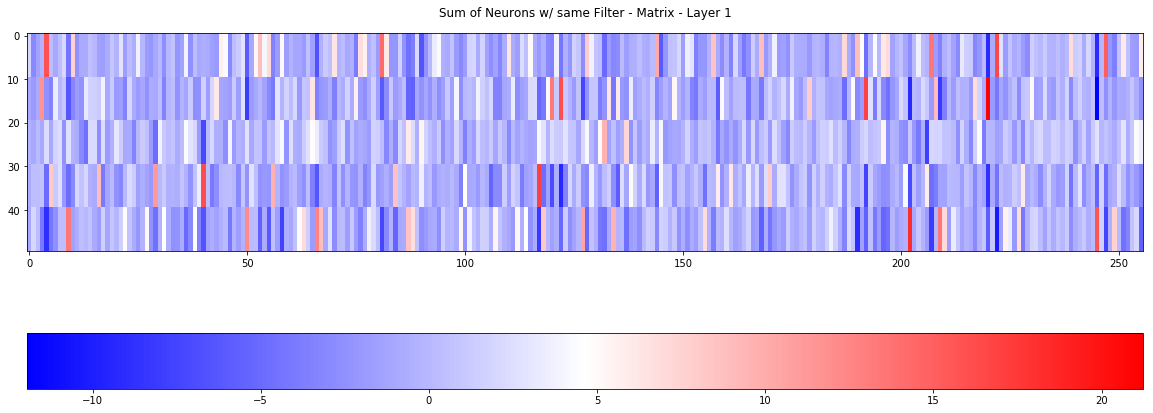

In [13]:
get_info_about_NR_vecs(NR_ms, 1)

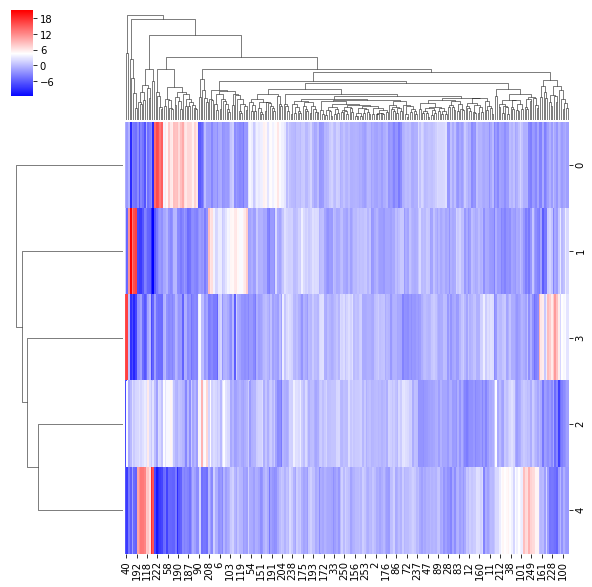

In [14]:
NR = NR_ms
layer = 1
neuronvectors = np.stack(arrays=[NR[0][layer], NR[1][layer], NR[2][layer], NR[3][layer], NR[4][layer]], axis=0)
sns.clustermap(np.sum(neuronvectors, axis=1), cmap='bwr')

## Betrachtung der Aktivierungen

In [15]:
activations_file_list = ["../resources/activations-five-authors/TrainSet-five_authors.txt-activations-"+str(i)+".npz" for i in range(35)]
text_file_list = ["../resources/activations-five-authors/TrainSet-five_authors.txt-texts-"+str(i)+".txt" for i in range(35)]

In [16]:
layer = 1
stack_for_filter = np.stack(arrays=[NR[0][layer], NR[1][layer], NR[2][layer], NR[3][layer], NR[4][layer]], axis=0)

stack_for_filter_argsorted_layer = np.copy(stack_for_filter)
for i, layer in enumerate(stack_for_filter):
    stack_for_filter_argsorted_layer[i] = np.argsort(layer, axis=None).reshape(layer.shape)

pos_filter = [np.where(x > 0) for x in stack_for_filter]
neg_filter = [np.where(x < 0) for x in stack_for_filter]
first_quarter_filter  = [np.where(x < np.max(x[i])*0.10) for i, x in enumerate(stack_for_filter_argsorted_layer)]
fourth_quarter_filter = [np.where(x > np.max(x[i])*0.90) for i, x in enumerate(stack_for_filter_argsorted_layer)]

filter_list = [pos_filter, neg_filter, first_quarter_filter, fourth_quarter_filter]

In [17]:
means = np.zeros([1,4,5])
ac_7s = np.zeros([1,980,256])
logits = np.zeros([1,2])
texts = []
for act_file_path, txt_file_path in zip(activations_file_list, text_file_list):
    log = np.load(act_file_path)['logits']
    filt = np.where(log[:,0] == log[:,1])
    act = np.load(act_file_path)['act_7'].reshape(-1, 980, 256)[filt]
    log = log[filt]
    
    txt = np.array(open(txt_file_path).read().split('\n'))[filt][0:len(act)]
    texts += list(txt)

    ac_7s = np.append(ac_7s, act, axis=0)
    means = np.append(means, np.array([[[np.mean(a[f[f_i]]) for f_i in range(5)] for f in filter_list] for a in act]), axis=0)
    logits = np.append(logits, log, axis=0)
    
ac_7s = ac_7s[1:,:,:]
means = means[1:,:,:]
logits = logits[1:,:]

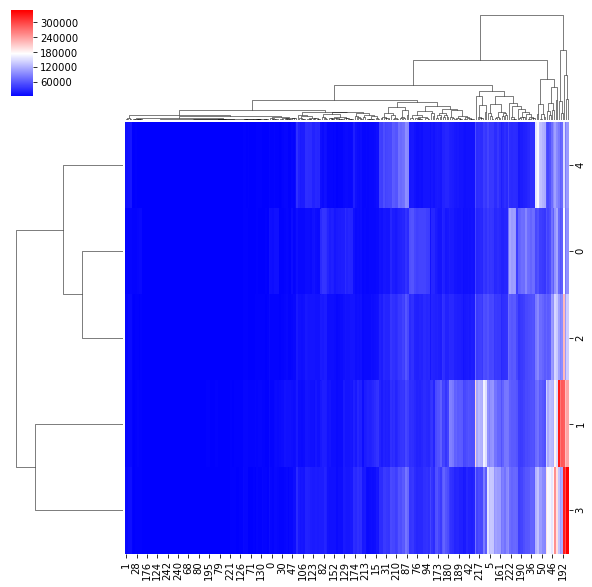

In [18]:
act_sums = []
for i in range(5):
    filt = np.where(logits[:,0] == i)
    act_sums.append(np.sum(np.sum(ac_7s[filt], axis=0), axis=0))
sns.clustermap(np.array(act_sums), cmap='bwr')